In [1]:
from panel_segmentation import utils
import glob
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import folium
import torch
from mmengine import Config
from mmdet.apis import init_detector, inference_detector
from mmdet.registry import VISUALIZERS
from shapely.geometry import Polygon
import mmcv

# Run the SOL-Searcher Pipeline on an Example Area

Take a gridded set of images of a small area and visualize them.

In [2]:
# Pull an area of images in the Austin metro area to run through the SOL-Searcher model. Use the generate_satellite_imagery_grid() function to do this.
northwest_lat, northwest_lon =  30.304107, -97.708710
southeast_lat, southeast_lon =  30.299329, -97.697781
google_maps_api_key = "YOUR_API_KEY_HERE"
zoom_level = 19
file_save_folder = "./panel_segmentation/examples/sol-searcher_data_examples"
grid_info_list = utils.generateSatelliteImageryGrid(northwest_lat, northwest_lon,
                                                       southeast_lat, southeast_lon,
                                                       google_maps_api_key,
                                                       file_save_folder,
                                                       zoom_level,
                                                       lat_lon_distance=.0014)

File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!


Visualize some of the imagery in the grid as reference.

30.304107_-97.70871.png
30.302707_-97.70871.png
30.301307_-97.70871.png
30.299907_-97.70871.png
30.298507_-97.70871.png
30.304107_-97.70731.png
30.302707_-97.70731.png
30.301307_-97.70731.png
30.299907_-97.70731.png
30.298507_-97.70731.png
30.304107_-97.70591.png
30.302707_-97.70591.png
30.301307_-97.70591.png
30.299907_-97.70591.png
30.298507_-97.70591.png
30.304107_-97.70451.png
30.302707_-97.70451.png
30.301307_-97.70451.png
30.299907_-97.70451.png
30.298507_-97.70451.png
30.304107_-97.70311.png
30.302707_-97.70311.png
30.301307_-97.70311.png
30.299907_-97.70311.png
30.298507_-97.70311.png
30.304107_-97.70171.png
30.302707_-97.70171.png
30.301307_-97.70171.png
30.299907_-97.70171.png
30.298507_-97.70171.png
30.304107_-97.70031.png
30.302707_-97.70031.png
30.301307_-97.70031.png
30.299907_-97.70031.png
30.298507_-97.70031.png
30.304107_-97.69891.png
30.302707_-97.69891.png
30.301307_-97.69891.png
30.299907_-97.69891.png
30.298507_-97.69891.png
30.304107_-97.69751.png
30.302707_-97.69

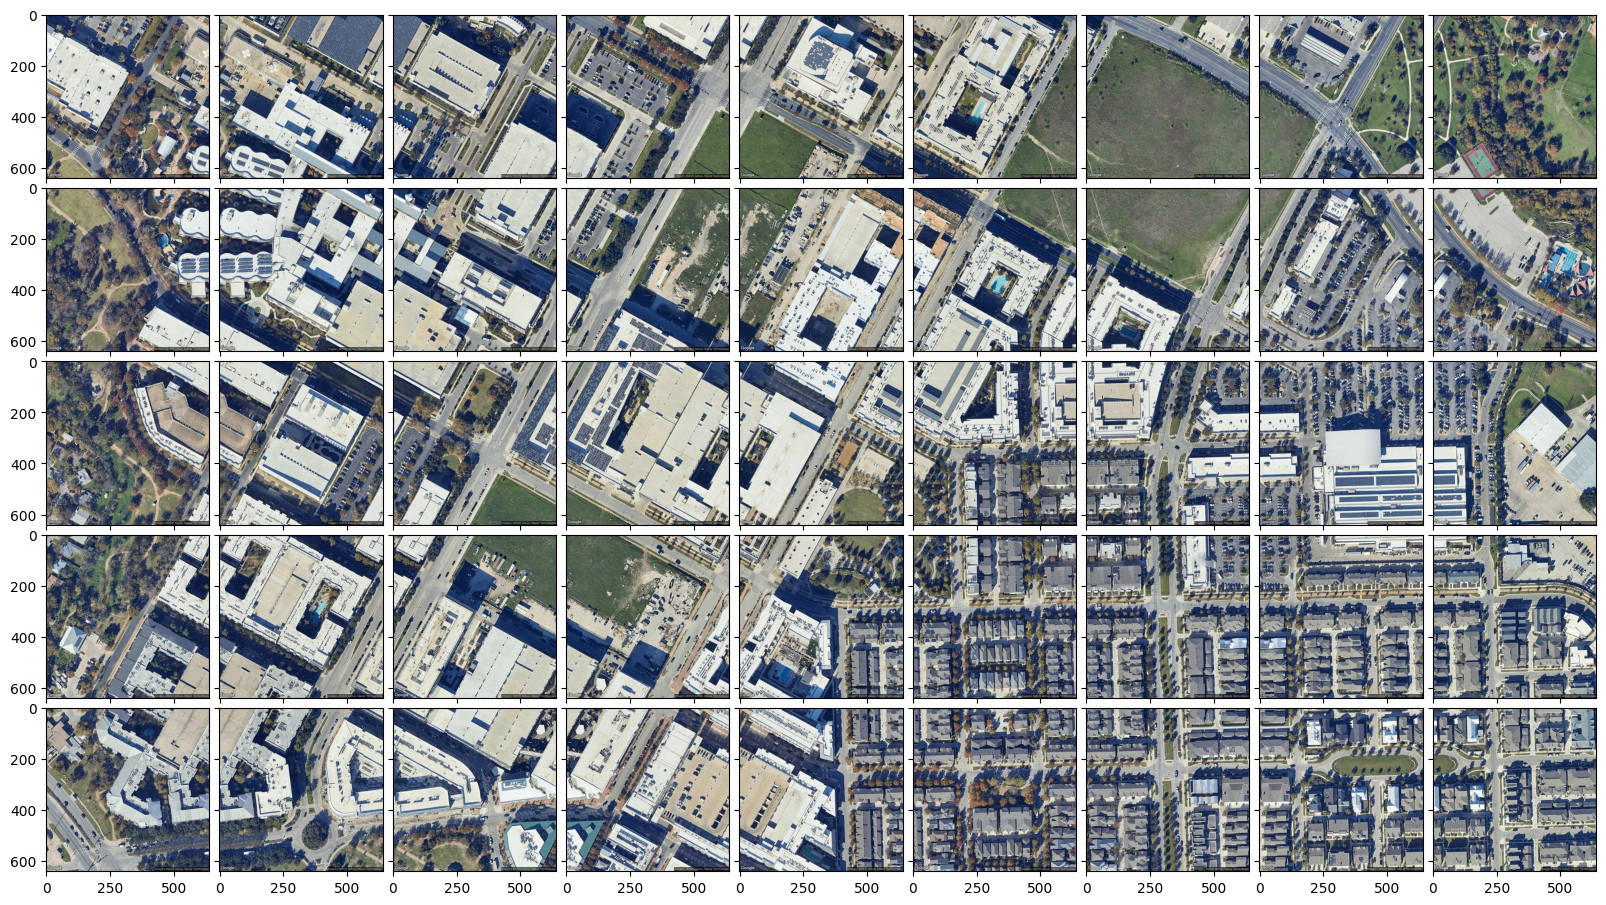

In [3]:
plot = utils.visualizeSatelliteImageryGrid(grid_info_list, file_save_folder)
plt.show()

Let's load in the SOL-searcher algorithm, run some imagery through it, and visualize the outputs.

C:\Users\Quyen\Documents\all_venv\panel_seg_extreme_weather\Lib\site-packages\mmdet\apis\inference.py:70: UserWarning: checkpoint is None, use COCO classes by default.
  warnings.warn('checkpoint is None, use COCO classes by default.')
C:\Users\Quyen\Documents\all_venv\panel_seg_extreme_weather\Lib\site-packages\mmdet\models\layers\se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
C:\Users\Quyen\Documents\all_venv\panel_seg_extreme_weather\Lib\site-packages\mmdet\models\backbones\csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
C:\Users\Quyen\Documents\all_venv\panel_seg_extreme_weather\Lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the 

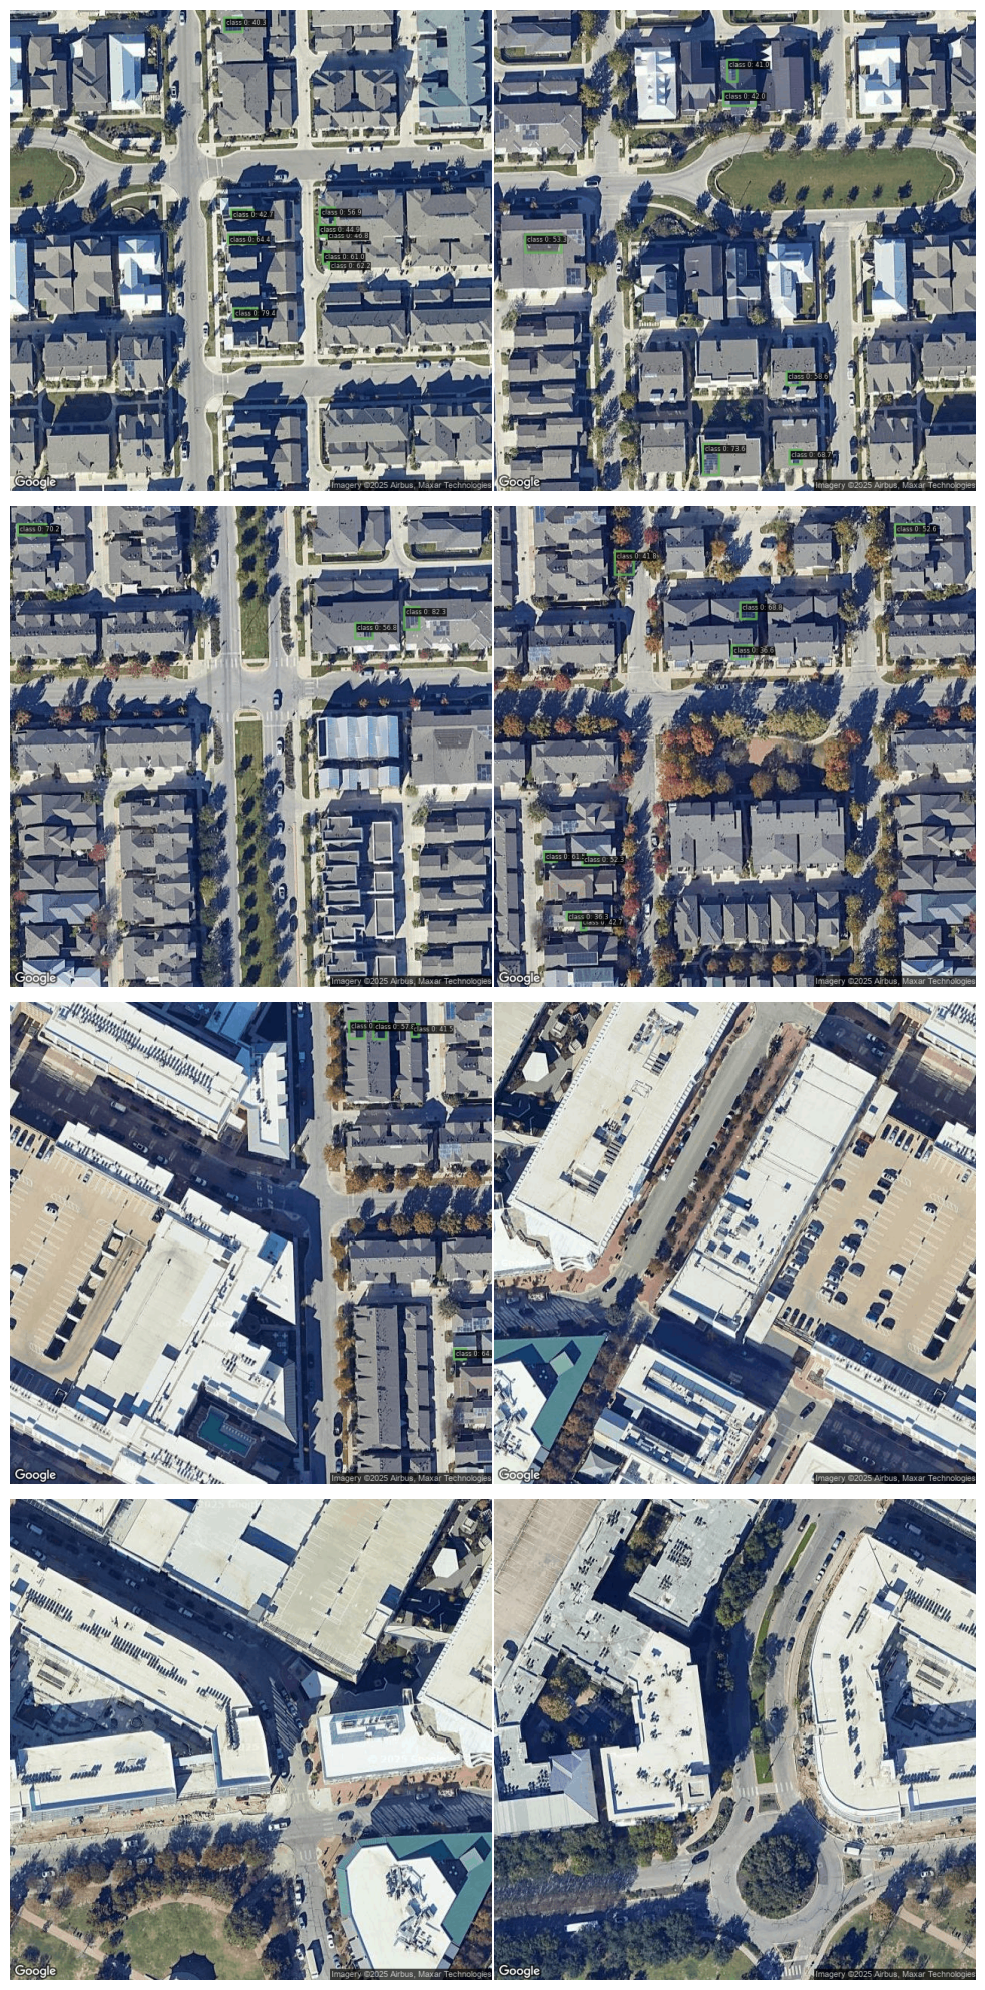

In [4]:
cfg = Config.fromfile("./panel_segmentation/models/sol_searcher_config.py")
checkpoint_file = "./panel_segmentation/models/sol_searcher_model.pth"
model = init_detector(cfg, device='cpu')
checkpoint = torch.load(checkpoint_file, map_location='cpu', weights_only=False)
model.load_state_dict(checkpoint['state_dict'])
visualizer = VISUALIZERS.build(model.cfg.visualizer)

# Visualize the first n images in example
n_images = 8
fig, axes = plt.subplots(((n_images + 1) // 2), 2, figsize=(10, 20))
axes = axes.ravel()

# Run inference on the example images
inference_data_list = list()
results = list()
grid_files = glob.glob(os.path.join(file_save_folder, "*.png"))
for i, file in enumerate(grid_files):
    img = mmcv.imread(file, channel_order='rgb')
    new_result = inference_detector(model, img)
    new_result.file = file
    results.append(new_result)
    # Visualize n images
    if i < n_images:
        visualizer.add_datasample(
              file,
              img,
              data_sample=new_result,
              draw_gt=None,
              wait_time=0,
              pred_score_thr=0.35
              )
        img = visualizer.get_image()
        axes[i].imshow(img)
        axes[i].axis('off')
plt.tight_layout()
plt.show()

Filter out the inference results with low prediction scores to reduce invalid detections and api queries.

In [5]:
filtered_results = []
for result in results:
    # Filter out inferences with prediction scores lower than 0.15
    if hasattr(result, "pred_instances"):
        save_inference = result.pred_instances.scores > 0.15
        result.pred_instances = result.pred_instances[save_inference]
    filtered_results.append(result)

Let's visualize some of the result outputs from the model.

In [6]:
# Loop through each inference result and get the lat-lon coordinates of the centroid of the box outputs
solar_location_list = list()
for result in filtered_results:
    file_name = os.path.basename(result.file)
    img_center_lat, img_center_lon = float(file_name.split("_")[0]), float(file_name.split("_")[-1].replace(".png", ""))
    image_x_pixels, image_y_pixels = result.img_shape
    boxes = result.pred_instances.bboxes
    for box in boxes:
        np_box = list(box.numpy())
        box_lat, box_lon = utils.getInferenceBoxLatLonCoordinates(np_box, img_center_lat, img_center_lon,
                                                                  image_x_pixels, image_y_pixels,
                                                                  zoom_level)
        solar_location_list.append((box_lat, box_lon))

If we want to associate individual installations to specific buildings, we can use Google's geocoding API to get individual addresses for each PV installation.

In [7]:
solar_install_address_list = list()
for lat_lon_coords in solar_location_list:
    latitude, longitude = lat_lon_coords[0], lat_lon_coords[1]
    # Look up the address associated with lat-lon coordinate
    solar_install_address = utils.generateAddress(latitude, longitude, google_maps_api_key)
    solar_install_address_list.append({"latitude": latitude,
                                       "longitude": longitude,
                                       "address": solar_install_address})

 We can then take the median lat-lon coordinates by address as our main address-level lat-lon coordinates, and visualize the resulting dataframe.

In [8]:
solar_address_df = pd.DataFrame(solar_install_address_list)
solar_address_df['median_latitude_address'] = solar_address_df.groupby("address")['latitude'].transform('median')
solar_address_df['median_longitude_address'] = solar_address_df.groupby("address")['longitude'].transform('median')
# Sort by address
solar_address_df = solar_address_df.sort_values(by='address')
solar_address_df.head(10)

latitude  longitude                                            address  \
195  30.304707 -97.707270  1301 Barbara Jordan Blvd #200G, Austin, TX 787...   
200  30.304367 -97.706636  1301 Barbara Jordan Blvd #200g, Austin, TX 787...   
194  30.304581 -97.706807  1301 Barbara Jordan Blvd #200g, Austin, TX 787...   
193  30.304578 -97.706616  1301 Barbara Jordan Blvd #200g, Austin, TX 787...   
201  30.304700 -97.707158    1301 Barbara Jordan Blvd, Austin, TX 78723, USA   
154  30.302776 -97.708072       1311 1/2 Philomena St, Austin, TX 78723, USA   
155  30.302753 -97.708074       1311 1/2 Philomena St, Austin, TX 78723, USA   
159  30.302778 -97.708074       1311 1/2 Philomena St, Austin, TX 78723, USA   
161  30.302748 -97.708080       1311 1/2 Philomena St, Austin, TX 78723, USA   
167  30.302781 -97.708084       1311 1/2 Philomena St, Austin, TX 78723, USA   

     median_latitude_address  median_longitude_address  
195                30.304707                -97.707270  
200                30.304578                -97.706636  
194                30.304578                -97.706636  
193                30.304578                -97.706636  
201                30.304700                -97.707158  
154                30.302764                -97.708082  
155                30.302764                -97.708082  
159                30.302764                -97.708082  
161                30.302764                -97.708082  
167                30.302764                -97.708082

Using aggregated address data, map the addresses containing solar installations in Folium. Please note, this map may include older satellite imagery and there may be discrepancies if solar installs are present in newer scans from Google Maps (i.e. solar was recently installed). Outputs of this algorithm should be manually reviewed to determine if there any discrepancies.

In [9]:
solar_address_df_agg = solar_address_df[['address',
                                         'median_latitude_address',
                                         'median_longitude_address']].drop_duplicates()

# Create folium map to visualize the solar addresses
folium_map = folium.Map(location=[solar_address_df_agg['median_latitude_address'].mean(),
                                  solar_address_df_agg['median_longitude_address'].mean()],
                        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                        attr = 'Esri',
                        name = 'Esri Satellite',
                        zoom_start=15,
                        max_zoom=19)
solar_feature_group = folium.FeatureGroup(name="solar", show=True)
for idx, row in solar_address_df_agg.iterrows():
    lat = row['median_latitude_address']
    lon = row['median_longitude_address']
    folium.CircleMarker([lat, lon],
                        color='b',
                        weight=.05,
                        fill=True,
                        fill_opacity=0.6,
                        fill_color='red',
                        radius=3).add_to(solar_feature_group)

folium_map.add_child(solar_feature_group)
folium_map